In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.18.0


Number of images found:  1040
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)
Shape of image:  (50, 200, 3)


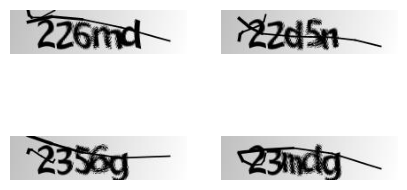

In [2]:

data_dir = Path(r"D:\sem 5\capstone\captcha\samples")
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))
sample_images = images[:4]
_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [3]:
characters = set()
captcha_length = []
dataset = []
for img_path in images:
    label = img_path.name.split(".png")[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))
    for ch in label:
        characters.add(ch)      
characters = sorted(characters)
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()

Number of unqiue charcaters in the whole dataset:  19
Maximum length of any captcha:  5
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset:  1040


,img_path,label
0,D:\sem 5\capstone\captcha\samples\226md.png,226md
1,D:\sem 5\capstone\captcha\samples\22d5n.png,22d5n
2,D:\sem 5\capstone\captcha\samples\2356g.png,2356g
3,D:\sem 5\capstone\captcha\samples\23mdg.png,23mdg
4,D:\sem 5\capstone\captcha\samples\23n88.png,23n88


In [4]:

train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=seed)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(val_data))
char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True


def generate_arrays(df, resize=True, img_height=50, img_width=200):
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))        
        img = (img/255.).astype(np.float32)
        label = df["label"][i] 
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    return images, np.array(labels)


train_data, train_labels = generate_arrays(df=train_data)
print("Number of training images: ", train_data.shape)
print("Number of training labels: ", train_labels.shape)


val_data, val_labels = generate_arrays(df=val_data)
print("Number of validation images: ", val_data.shape)
print("Number of validation labels: ", val_labels.shape)

Number of training samples:  936
Number of validation samples:  104
Number of training images:  (936, 50, 200)
Number of training labels:  (936,)
Number of validation images:  (104, 50, 200)
Number of validation labels:  (104,)


In [5]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=50,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_len = len(curr_batch_idx)
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
                
        for j, idx in enumerate(curr_batch_idx):
            img = self.data[idx].T
            img = np.expand_dims(img, axis=-1)
            text = self.labels[idx]
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [6]:
batch_size = 16
img_width=200
img_height=50 
downsample_factor=4
max_length=5
train_data_generator = DataGenerator(data=train_data,
                                     labels=train_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

valid_data_generator = DataGenerator(data=val_data,
                                     labels=val_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss



In [8]:
def build_model():

    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
   
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
   
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
   
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
   
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    model.compile(optimizer=sgd)
    return model

In [9]:
model = build_model()
model.summary()

c:\Users\Tanaz\envs\test\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 200, 50,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ input_data[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_label         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 20)    │      2,580 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 1)         │          0 │ input_label[0][0… │
│                     │                   │            │ dense2[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50


c:\Users\Tanaz\envs\test\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\Tanaz\envs\test\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_data', 'input_label', 'input_length', 'label_length']. Received: the structure of inputs={'input_data': '*', 'input_label': '*', 'input_length': '*', 'label_length': '*'}
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - loss: 680.4410 - val_loss: 253.2030
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 261.9832 - val_loss: 251.0794
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 258.9326 - val_loss: 246.8973
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 253.2920 - val_loss: 245.2666
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 252.1861 - val_loss: 238.5858
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 245.6459 - val_loss: 234.5959
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 242.2955 - val_loss: 232.5268
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 240.9663 - val_loss: 229.7032
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 236.2648 - val_loss: 226.9920
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 236.0108 - val_loss: 221.4718
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 228.4496 - val_loss: 220.1225
Epoch 12/50
59/59 ━━━━━━━━━━━

In [11]:

output_layer = model.get_layer(name='dense2')
prediction_model = keras.models.Model(inputs=model.inputs, outputs=output_layer.output)
prediction_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 200, 50,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ input_data[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_label         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 20)    │      2,580 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    

    return output_text

In [13]:

for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    input_length = inp_value['input_length']  
    label_length = inp_value['label_length']  
    labels = inp_value['input_label']
    
    
    preds = prediction_model.predict([X_data,labels, input_length, label_length])
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break


c:\Users\Tanaz\envs\test\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_data', 'input_label', 'input_length', 'label_length']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Ground truth: 8xef7 	 Predicted: 8xef7
Ground truth: wecfd 	 Predicted: wecfd
Ground truth: 373gb 	 Predicted: 373gb
Ground truth: bgb48 	 Predicted: bgb48
Ground truth: be6np 	 Predicted: be6np
Ground truth: xdn65 	 Predicted: xdn65
Ground truth: ffnxn 	 Predicted: ffnxn
Ground truth: 76y6f 	 Predicted: 76y6f
Ground truth: 43xfe 	 Predicted: 43xfe
Ground truth: fg38b 	 Predicted: fg38b
Ground truth: 43gey 	 Predicted: 43gey
Ground truth: 6g45w 	 Predicted: 6g45w
Ground truth: 728n8 	 Predicted: 728n8
Ground truth: 556wd 	 Predicted: 556wd
Ground truth: d3c7y 	 Predicted: d3c7y
Ground truth: mggce 	 Predicted: mggce


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.preprocessing import LabelEncoder

all_pred_texts = []
all_orig_texts = []
for p, (inp_value, _) in enumerate(valid_data_generator):
    if p>8:
        break
    X_data = inp_value['input_data']
    input_length = inp_value['input_length']
    label_length = inp_value['label_length']
    labels = inp_value['input_label']
    try:
        preds = prediction_model.predict([X_data, labels, input_length, label_length])
        pred_texts = decode_batch_predictions(preds)
        orig_texts = []
        for label in labels:
            text = ''.join([labels_to_char[int(x)] for x in label])
            orig_texts.append(text)

        all_pred_texts.extend(pred_texts)
        all_orig_texts.extend(orig_texts)
    except Exception as e:
        continue
    

y_true_flat = [label for text in all_orig_texts for label in text]
y_pred_flat = [label for text in all_pred_texts for label in text]


le = LabelEncoder()
le.fit(y_true_flat)  
y_true_encoded = le.transform(y_true_flat)
y_pred_encoded = le.transform(y_pred_flat)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\Tanaz\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [23]:
accuracy = accuracy_score(y_true_encoded, y_pred_encoded)
precision = precision_score(y_true_encoded, y_pred_encoded, average='weighted')
recall = recall_score(y_true_encoded, y_pred_encoded, average='weighted')
f1 = f1_score(y_true_encoded, y_pred_encoded, average='weighted')
report = classification_report(y_true_encoded, y_pred_encoded, target_names=le.classes_)
print("Classification Report:\n", report)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Classification Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        34
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        27
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        32
           b       1.00      1.00      1.00        28
           c       1.00      0.96      0.98        26
           d       1.00      1.00      1.00        26
           e       0.95      1.00      0.98        21
           f       1.00      1.00      1.00        34
           g       1.00      1.00      1.00        23
           m       1.00      1.00      1.00        20
           n       1.00      1.00      1.00        47
           p       1.00      1.00      1.00        25
           w       1.00      1.00      1.00        29
   

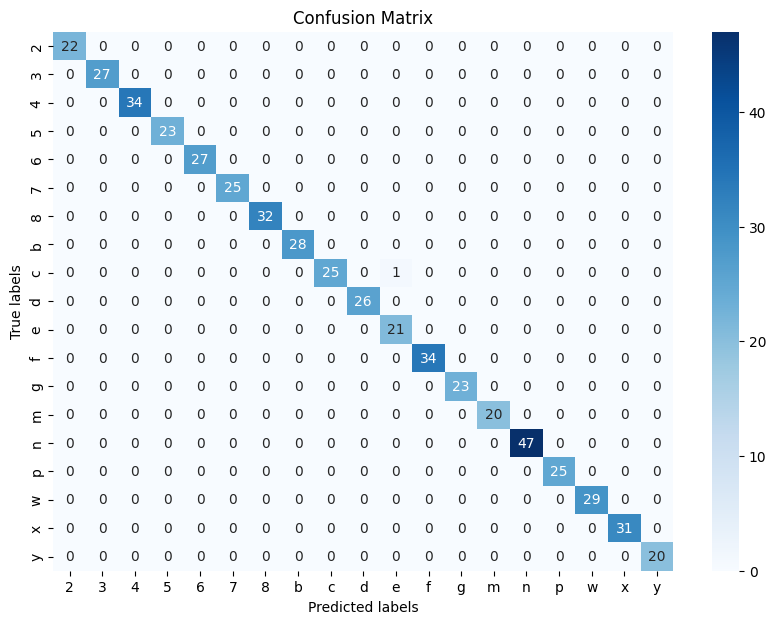

In [24]:

cm = confusion_matrix(y_true_encoded, y_pred_encoded)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()